In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from ipynb.fs.full.Preprocessing import preprocess
from collections import Counter


In [2]:
def label_corrector(array):
    temp = list()
    seen_labels = set()
    dict_of_labels = dict()
    label_counter = -1
    for label in array:
        if label in seen_labels:
            temp.append(dict_of_labels[label])
        else:
            label_counter += 1
            dict_of_labels[label] = label_counter
            seen_labels.add(label)
            temp.append(label_counter)
    return np.array(temp)

def k_fold_preprocess(row_count=100000, k=10):
    """
    Splits the dataset into k groups
    
    Output: [ ((validation_1_x, validation_1_y), (training_1_x, training_1_y)),
              ((validation_2_x, validation_2_y), (training_2_x, training_2_y)),
              ...
              ((validation_k_x, validation_k_y), (training_k_x, training_k_y))]
    """
    df = pd.read_csv('star_classification.csv')
    df.drop(['obj_ID'], axis = 1,inplace=True) #dropping OBJ_ID feature as it is just the ID
    df.drop(['rerun_ID'], axis = 1,inplace=True)#dropping rerun_ID feature as it is the same for all
    df.drop(['run_ID'], axis = 1,inplace=True)
    df.drop(['field_ID'], axis = 1,inplace=True)
    df.drop(['spec_obj_ID'], axis = 1,inplace=True)
    
    data = np.array(df)
    data = data[:row_count]
    class_index = 8
    data[:,class_index] = label_corrector(data[:,class_index])
    
    complete_x = np.concatenate((data[:,:class_index],data[:,class_index+1:]),axis=1)
    complete_y = data[:,class_index]
    
    # Remove outliers from the dataset
    tdata = np.transpose(complete_x)
    
    IQRs = list()
    outlier_rows = np.array([])
    for ind, col in  enumerate(tdata):
        if ind in [3,4,5,6,2]:
            percentiles = np.percentile(col,[25,75])
            IQR = percentiles[1]-percentiles[0]
            right = (col>percentiles[1]+1.5*IQR)*1
            left = (col < (percentiles[0]-1.5*IQR))*1
            outliers = right+left
            #print(f"{ind}th feature has {sum(outliers)} outliers.")
            outlier_rows = np.append(outlier_rows,np.where(outliers == 1)[0])
            
    outlier_rows = np.array(list(set(outlier_rows)))
    outlier_rows = np.array(outlier_rows,dtype = 'int')
    
    complete_x = np.delete(complete_x,outlier_rows,axis=0)
    complete_y = np.delete(complete_y,outlier_rows,axis=0)
    
    # Standardize the dataset
    means_x = list()
    stds_x = list()

    for ind in range(np.shape(complete_x)[1]):
        col = complete_x[:,ind]
        mean = np.mean(col)
        std = np.std(col)
        means_x.append(mean)
        stds_x.append(std)
        complete_x[:,ind] = (col-mean)/std
        
    """
    Splits the dataset into k groups
    
    Output: [ ((validation_1_x, validation_1_y), (training_1_x, training_1_y)),
              ((validation_2_x, validation_2_y), (training_2_x, training_2_y)),
              ...
              ((validation_k_x, validation_k_y), (training_k_x, training_k_y))]
    """
        
    folds = []
    fold_size = complete_x.shape[0] // k
    prev_index = 0
    for i in range(k):
        validation_x = complete_x[prev_index:prev_index + fold_size]
        validation_y = complete_y[prev_index:prev_index + fold_size]
        
        training_x = np.concatenate((complete_x[0:prev_index], complete_x[prev_index+fold_size:]), axis=0)
        training_y = np.concatenate((complete_y[0:prev_index], complete_y[prev_index+fold_size:]), axis=0)
        
        folds.append( ((validation_x, validation_y), (training_x, training_y)) )
        prev_index += fold_size
        
        
    return folds

# Decision Tree Implementation

In [2]:
#train_x, train_y, test_x, test_y = preprocess(100000)

In [3]:
#This one uses Counter
class Node:
    #The tree is defined with nodes that have nodes in them. The process will be implemented recursively 
    #in later parts.
    
    def __init__(self, depth=None,right_node=None, left_node=None,node_type=None,node_class = None,split_feature = None,split_threshold = None ):
        #The building block of the tree.
        #The tree is a node that have nodes...
        self.left_node = left_node
        self.right_node =right_node
        self.node_type = node_type
        self.node_class = node_class
        self.split_feature = split_feature
        self.split_threshold = split_threshold

class DecisionTree:
    def __init__(self, data=None, labels=None,max_split =500,min_member=5):
        self.max_split=max_split
        self.data = data
        self.labels = labels
        self.min_member=min_member
        self.splitnumbers = list()
    def get_class(self,labels):
        unique, counts = np.unique(labels, return_counts=True)
        counter = dict(zip(unique, counts))
        return max(labels, key=lambda x: counter[x])

    def run(self,data,labels,split_number):

        #This is the function where the recursion happens: nodes that have nodes.
       
        split_feature,split_threshold,gini = self.get_splitting_point(data,labels) #returns the feature index and the threshold
        if gini > 0 and split_number< self.max_split and len(labels) > self.min_member: #split until spliting conditions are met
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature, split_threshold, data,labels)
            self.splitnumbers.append(split_number)
            right_node = self.run(data=right_data,labels = right_labels,split_number=split_number+1) 
            left_node = self.run(data = left_data,labels=left_labels,split_number=split_number+1)
            return Node(node_type = "branch",right_node = right_node, left_node = left_node,split_feature=split_feature,split_threshold=split_threshold,depth=split_number  )
        else:
            return Node(node_type = "leaf",node_class = self.get_class(labels))
    def get_splitting_point(self,data,labels):
        num_instances, num_features = np.shape(data)
        gini =np.inf
        for feature in range(num_features):
            split_threshold, gini_gain = self.best_of_feature_split(data,labels,feature)
            if gini_gain<gini:
                gini = gini_gain
                best_split_threshold , best_split_feature = split_threshold,feature
        return best_split_feature,best_split_threshold,gini 
        #return split_feature, split_threshold, gini_gain
    def best_of_feature_split(self,data,labels,split_feature):
        feature_col = data[:,split_feature]
        thresholds = np.unique(feature_col, return_counts=False) #using the values as thresholds to make it efficient
        min_gini = np.inf 
        for threshold in thresholds:
            right_data, left_data,right_labels,left_labels = self.get_split(split_feature,threshold,data,labels)
            len_right = len(right_labels)
            len_left = len(left_labels)
            gini = self.gini_index(right_labels)*(len_right/(len_right+len_left))+self.gini_index(left_labels)*(len_left/(len_right+len_left))
            if gini < min_gini:
                min_gini = gini
                split_threshold = threshold
        return split_threshold, min_gini
    def get_split(self,split_feature,split_threshold,data,labels):
        feature_col = data[:,split_feature]
        pos1 =np.where(feature_col>split_threshold)[0]
        pos2 = np.where(feature_col<=split_threshold)[0]
        right_data = data[pos1]
        left_data=data[pos2]
        left_labels=labels[pos2] 
        right_labels=labels[pos1]  
        return right_data, left_data,right_labels,left_labels   
    def fit(self):
        self.decision_maker = self.run(self.data,self.labels,0) #this returns a node instance 
    def predict(self,new_data):
        predictions = list()
        for row in new_data:
            predictions.append(self.infer(self.decision_maker,row))
        return predictions
            
    def infer(self,node,datapoint):
        if node.node_type == "branch":
            val = datapoint[node.split_feature] 
            if val > node.split_threshold:
                return self.infer(node.right_node,datapoint)
            else:
                return self.infer(node.left_node,datapoint)
        elif node.node_type == "leaf":
                return node.node_class
    def gini_index(self,labels):
        length = len(labels)

        counter = Counter(labels)
        gini = 1
        for val in counter.values():
            gini -= (val/length)**2
        return gini
    


**Training and Inference Time**

In [13]:
from time import time
data_count = 5000

k = 10
folds = k_fold_preprocess(data_count, k)

max_splits = [3,4,5,6,7,8,9]
average_accuracies = []
for split in max_splits:
    acc_rate = 0
    for i in range(k):
        test_x = folds[i][0][0]
        test_y = folds[i][0][1]

        train_x = folds[i][1][0]
        train_y = folds[i][1][1]

        Tree = DecisionTree(train_x,train_y,max_split = split)
        Tree.fit()

        predictions = Tree.predict(test_x)

        count = 0
        for ind,prediction in enumerate(predictions):
            if test_y[ind]==prediction:
                count+=1
        
        acc = (count / len(predictions)) * 100
        acc_rate += acc
    
        print(f"When max_split = {split}, on fold: {i}, accuracy: {(count/len(predictions))*100:.2f}")
        
    average_accuracies.append(acc_rate / k)
    print(f"Average accuracy when max_split is {split}: {acc_rate / k:.2f} \n\n")

When max_split = 3, on fold: 0, accuracy: 96.36
When max_split = 3, on fold: 1, accuracy: 95.35
When max_split = 3, on fold: 2, accuracy: 94.75
When max_split = 3, on fold: 3, accuracy: 95.15
When max_split = 3, on fold: 4, accuracy: 93.54
When max_split = 3, on fold: 5, accuracy: 95.76
When max_split = 3, on fold: 6, accuracy: 94.14
When max_split = 3, on fold: 7, accuracy: 95.76
When max_split = 3, on fold: 8, accuracy: 89.49
When max_split = 3, on fold: 9, accuracy: 94.14
Average accuracy when max_split is 3: 94.44 


When max_split = 4, on fold: 0, accuracy: 95.96
When max_split = 4, on fold: 1, accuracy: 94.95
When max_split = 4, on fold: 2, accuracy: 95.56
When max_split = 4, on fold: 3, accuracy: 96.36
When max_split = 4, on fold: 4, accuracy: 94.14
When max_split = 4, on fold: 5, accuracy: 96.36
When max_split = 4, on fold: 6, accuracy: 95.56
When max_split = 4, on fold: 7, accuracy: 96.57
When max_split = 4, on fold: 8, accuracy: 89.90
When max_split = 4, on fold: 9, accuracy:

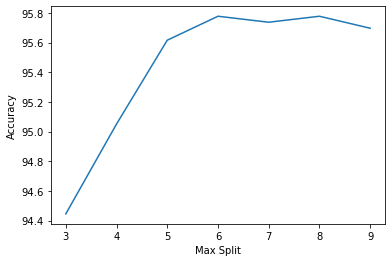

In [14]:
plt.plot(max_splits, average_accuracies)
plt.xlabel("Max Split")
plt.ylabel("Accuracy")
plt.show()

**Evaluation Metrics**

In [15]:
def confusion_matrice(pred,truth,num_of_class):
    """
    Return the confusion matrix where the column indexes are predictions and 
    row indexes are ground truths.
    
    """
    confusion_mtrx=np.zeros((num_of_class,num_of_class),dtype=np.int32)
    for ind,prediction in enumerate(predictions):
        confusion_mtrx[truth[ind]][prediction]+=1
    
    #dataframe = pd.DataFrame(data=confusion_mtrx,   index=np.arange(0,num_of_class),   columns=np.arange(0,num_of_class))
    #dataframe = dataframe.style.set_caption('The Confusion Matrix ')
    #return dataframe
    return confusion_mtrx
def accuracy(pred,truth):
    count = 0

    for ind,prediction in enumerate(predictions):
        if truth[ind]==prediction:
            count+=1
    accuracy = (count/len(predictions))*100
    return accuracy


In [ ]:
#print(accuracy(predictions, full_test_label))
#confusion_matrice(predictions, full_test_label,3)

In [ ]:
#s = sn.heatmap(confusion_matrice(predictions, full_test_label,3), annot=True, fmt='g')
#s.set(xlabel='Predicted Labels', ylabel='True Labels')
#plt.show()

 **Performance Analysis**

In [ ]:
Tree = DecisionTree(train_x[:1000],train_y[:1000])
from line_profiler import LineProfiler
lp = LineProfiler()
lp.enable_by_count()
lp.add_function(Tree.best_of_feature_split)
lp.add_function(Tree.get_split)
lp.add_function(Tree.get_splitting_point)
lp.add_function(Tree.run)
lp.add_function(Tree.gini_index)
lp_wrapper = lp(Tree.fit)
Tree.fit()
lp.print_stats()